# Unused Galaxies

Does it ever improve a metric to not use some galaxies?  Study this numerically by adding a bin whose dn/dz is the total dn/dz of the sample.

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [13]:
from zotbin.binned import *
import zotbin.group
import zotbin.reweight

In [4]:
init_data = load_binned('binned_3_80.npz')

/Users/david/anaconda3/envs/jax/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [17]:
_, _, _, zhist, _ = zotbin.group.load_groups('group_cos_80_150.npz')

In [26]:
mixing = zhist / zhist.sum()

In [12]:
with np.load('dndz-4.npz') as keys:
    dndz_bin = keys['dndz']
    weights = keys['weights']
    zedges = keys['zedges']

In [27]:
def get_binned_scores(weights, mixing, gals_per_arcmin2=20., fsky=0.25):
    """Calculate all of the 3x2 metrics: SNR2, FOM, FOM_DETF.
    """
    weights = jnp.asarray(weights)
    mixing = jnp.array(mixing)
    w = jnp.dot(weights, mixing)
    weights = jnp.array([w, w])
    return zotbin.reweight.reweighted_metrics(weights, *init_data[1:], gals_per_arcmin2, fsky)

In [28]:
get_binned_scores(weights, mixing)

{'FOM_3x2': DeviceArray(2518.633, dtype=float32),
 'FOM_DETF_3x2': DeviceArray(55.56691, dtype=float32),
 'SNR_3x2': DeviceArray(1205.3645, dtype=float32)}

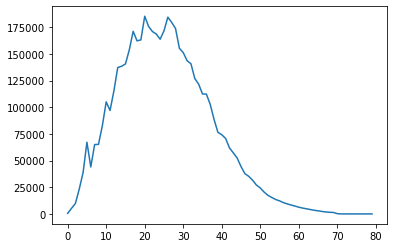

In [24]:
plt.plot(zhist.sum(axis=0))

FOM_3x2: 2480.50293 - 2412.97656 = 67.52637
FOM_DETF_3x2: 53.93300 - 51.81394 = 2.11906
SNR_3x2: 1191.74573 - 1189.42847 = 2.31726


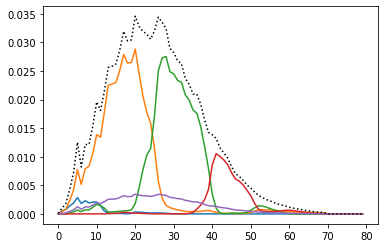

In [37]:
def diluted(frac):
    nbin, ngrp = weights.shape
    new_weights = np.zeros((nbin + 1, ngrp + 1))
    new_weights[:nbin, :ngrp] = weights
    new_weights[nbin, ngrp] = 1.
    
    _, ninit = zhist.shape
    mixing_sum = mixing.sum(axis=0).reshape(1, -1)
    new_mixing = np.vstack(((1 - frac) * mixing, frac * mixing_sum))
    
    plt.plot(new_weights.dot(new_mixing).T)
    plt.plot(mixing_sum[0], 'k:')
    
    scores1 = get_binned_scores(new_weights, new_mixing)
    scores2 = get_binned_scores(new_weights[:-1, :-1], new_mixing[:-1])
    
    for m in scores1:
        s1 = scores1[m]
        s2 = scores2[m]
        ds = s1 - s2
        print(f'{m}: {s1:.5f} - {s2:.5f} = {ds:.5f}')
    
diluted(0.1)

FOM_3x2: 2511.43042 - 2498.20117 = 13.22925
FOM_DETF_3x2: 55.25064 - 54.82654 = 0.42410
SNR_3x2: 1202.79968 - 1202.36755 = 0.43213


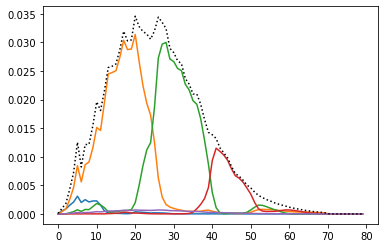

In [38]:
diluted(0.02)

FOM_3x2: 2243.47949 - 1862.69324 = 380.78625
FOM_DETF_3x2: 45.66130 - 35.14860 = 10.51270
SNR_3x2: 1106.74988 - 1087.26172 = 19.48816


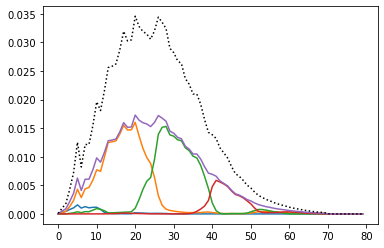

In [39]:
diluted(0.5)

FOM_3x2: 1352.72742 - 714.86115 = 637.86627
FOM_DETF_3x2: 26.57341 - 10.98117 = 15.59224
SNR_3x2: 857.90619 - 723.81274 = 134.09344


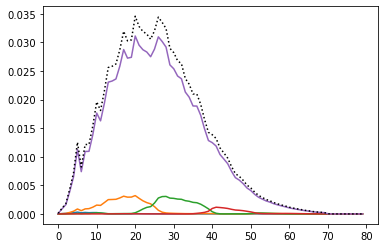

In [40]:
diluted(0.9)

Conclusion: adding bin with no redshift separation always improves the 3x2 metrics.